# Práctica 1

## Preparación del entorno

In [22]:
import tensorflow as tf
import keras as ker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


### Variables a definir

In [23]:
# No tocar
num_clases = 10
# La foto es 128x96
xpixel = 224
ypixel = 224
# Tocar
n_neuronas_conv1 = 64
n_neuronas_conv2 = 128
n_neuronas_conv3 = 256
l_rate = 0.00001  # empezar en 0.001 e ir bajando para el estudio
epoch = 15
batch = 16  # Realmente en 1 esta bien esto es mas para tiempos de ejecucion con grandes cantidades de datos


# Preprocesamiento de datos

### Creación de los dataset

Para el correcto entreno de la red neuronal es necesario crear dos dataset, uno de entreno y uno de validación. Este proceso lo hacemos gracias a la función **tf.keras.preprocessing.image_dataset_from_directory** que nos permite dado un directorio, recorrerlo iterativamente y crear una "lista de tuplas de la siguiente forma":

- Primero una imagen convertida en array numérico de tres dimensiones (RGB)
- A esta imagen esta asginado su clase. Esta clase la función la asigna directamente según en el subdirectorio en el que este localizada. Como podemos ver, nuestro directorio de imágenes tiene subdirectorios según la clase, de ahí coge el label creando así la tupla.

In [24]:
def meterdatos(batch):

    image_size = (xpixel, ypixel)
    batch_size = batch

    # Primero creamos el test con el 80% de todas las imagenes que se nos dan
    train_generator_t = tf.keras.preprocessing.image_dataset_from_directory(
        directory=r'../Dataset/imgs/train/',
        label_mode='categorical',
        validation_split=0.2,
        subset="training",
        shuffle=True,
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    
    # Segundo creamos el validation con el 20% de todas las imagenes que se nos dan
    train_generator_v = tf.keras.preprocessing.image_dataset_from_directory(
        directory=r'../Dataset/imgs/train/',
        label_mode='categorical',
        validation_split=0.2,
        subset="validation",
        shuffle=True,
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )

    """
    
    Matizar un punto importante y es que ambos tienen el "batchsize". El batch size se define como
    el número de muestras que se propagarán a través de la red. De esta manera, a la red no solo le pasamos
    el 80%/20% de las muestras, si no que ese 80%/20% a su vez es dividido entre el batch size.

    Por ejemplo, supongamos que tenemos 1050 muestras de entrenamiento y queremos configurar un 
    tamaño de lote igual a 100. El algoritmo toma las primeras 100 muestras (del 1 al 100) del 
    conjunto de datos de entrenamiento y entrena la red. A continuación, toma las segundas 100 muestras 
    (del 101 al 200) y vuelve a entrenar la red.
    
    Por tanto, siempre entrenamos con todas las imágenes (el 80% acaba siendo procesado entero por la red)
    pero en cada iteración solo procesa el batch size de imágenes

    """

    return train_generator_t, train_generator_v


### Creación de los dataset con Augmentation

Esta función es exactamente igual que la anterior pero tiene un valor añadido extremadamente alto. Al igual que la función anterior dividimos los dataset y automáticamente los procesamos mediante el recorrido iterativo de sus directorios. Pero en este caso tanto el entreno como la validación sufren cambios. Estos cambios son mediante Augmentation que consiste en crear sintéticamente nuevos datos de entrenamiento aplicando algunas transformaciones en los datos de entrada. 

De esta manera a cada imagen le pasamos unos "filtros" que la distorsionan, de tal manera que entrenamos la red más a fondo puesto que no aprende a reconocer a una imagen con X características si no que amplia mucho su visión. En la siguiente imagen podemos ver un ejemplo de Augmentation:

![Augmentation](https://i.ibb.co/k2ZXKrR/Captura-de-pantalla-de-2022-03-30-09-54-39.png)

In [25]:
def meterdatosaug():

    train_datagen = ImageDataGenerator(  # Aqui se hacen los cambios a las imagenes
        rescale=1./255, # Normalizar
        shear_range=0.2, # Mover la imágen x pixeles
        zoom_range=0.2, # Zoom
        horizontal_flip=True, # 180º flip
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255) # Simplemente normalizar

    train_generator = train_datagen.flow_from_directory(
        directory=r'../Dataset/imgs/train/',
        target_size=(xpixel, ypixel),
        batch_size=batch,
        class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
        directory=r'../Dataset/imgs/train/',
        target_size=(xpixel, ypixel),
        batch_size=batch,
        class_mode='categorical')
        
    return train_generator, validation_generator


# Creación de la red

Parámetros de entrada:

- n_conv1 = nº neuronas capa de convolución 1 (16)
- n_conv2 = nº neuronas capa de convolución 2 (32)
- n_conv3 = nº neuronas capa de convolución 3 (64)

Podemos ver como las neuronas van aumentando, esto es principalemente porque en cada convolución
vamos haciendo más preciso y más pequeña la característica que queremos estudiar

Parámetros de entrada:

- x = Altura imágen
- y = Anchura imágen
- lr = Learning rate

In [26]:
def Modelar_red(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))

    model.add(Conv2D(filters=n_conv1, kernel_size=(
        3, 3), padding='same', activation='relu'))
    # Capas convolucionales
    model.add(MaxPooling2D())
    #   >este bloque se puede seguir añadiendo, quiza con menos neuronas, o menos capas convolucionales, pongo dos por dar un ejemplo nada mas
    # (3,3) es mucho se recomienda unsar 1x1 cuando las img no son mayores de 128x128 la nuestra es 128x96
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    # model.add(Dropout(0.2)) # dropout

    model.add(MaxPooling2D())
   # model.add(Conv2D(n_conv3,(3,3),activation='relu',padding='same'))                                       #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    # model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model


# Mas redes para ver como va afectando, ejecutar para ver que pasa

Primero, crearé un par de redes con pocos POOLING's. Uno que solo tenga el ultimo y otro que solo tenga un par, con dos capas convolucionales anidadas.
Importante, al evaluarlas, compararlas siempre con los mismos valores para el numero de neuronas, y comprobar tambien diferentes valores para estos.

#### En todas seria bueno descomentar el dropout para ver como afecta

In [27]:
def Modelar_red_2(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))

    model.add(Conv2D(filters=n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [28]:
def Modelar_red_3(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))

    model.add(Conv2D(filters=n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    # capas convolucionales concatenadas
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Ahora quiero ver que pasa al aumentar demasiado en numero de capas convoluncionales. 

In [29]:
def Modelar_red_4(n_conv1, n_conv2, n_conv3, x, y, lr):
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))

    model.add(Conv2D(filters=n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))                                   
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D()) #model.add(MaxPooling2D(pool_size=(2,2)))
    # model.add(Dropout(0.2))
    model.add(Conv2D(n_conv3*2, (3, 3), activation='relu', padding='same'))    # lo multiplico por 4 para que aumente la profundidad                               
    model.add(Conv2D(n_conv3*4, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))  # red fully-connected
    model.add(Dense(64, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Y ahora molaria saber cuanto afecta la capa de MLP, que creo que va a ser la clave para que la red sea perfecta

##### Valor inicial 2^15 = 32768, el segundo es la mitad

In [30]:
def Modelar_red_5(n_conv1, n_conv2, n_conv3, x, y, lr): # red original con los valores de MLP cambiados
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))

    model.add(Conv2D(filters=n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    # Capas convolucionales
    model.add(MaxPooling2D())
    #   >este bloque se puede seguir añadiendo, quiza con menos neuronas, o menos capas convolucionales, pongo dos por dar un ejemplo nada mas
    # (3,3) es mucho se recomienda unsar 1x1 cuando las img no son mayores de 128x128 la nuestra es 128x96
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    # model.add(Dropout(0.2)) # dropout

    model.add(MaxPooling2D())
   # model.add(Conv2D(n_conv3,(3,3),activation='relu',padding='same'))                                       #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    # model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(32768, activation='relu'))  # red fully-connected
    model.add(Dense(32768/2, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Valor incial 2^20 = 1048576 (quizá aqui me he pasado, si tarda mucho abortamos mision)

In [31]:
def Modelar_red_6(n_conv1, n_conv2, n_conv3, x, y, lr): # red original con los valores de MLP cambiados
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))

    model.add(Conv2D(filters=n_conv1, kernel_size=(3, 3), padding='same', activation='relu'))
    # Capas convolucionales
    model.add(MaxPooling2D())
    #   >este bloque se puede seguir añadiendo, quiza con menos neuronas, o menos capas convolucionales, pongo dos por dar un ejemplo nada mas
    # (3,3) es mucho se recomienda unsar 1x1 cuando las img no son mayores de 128x128 la nuestra es 128x96
    model.add(Conv2D(n_conv2, (3, 3), activation='relu', padding='same'))
    # model.add(Dropout(0.2)) # dropout

    model.add(MaxPooling2D())
   # model.add(Conv2D(n_conv3,(3,3),activation='relu',padding='same'))                                       #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(n_conv3, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D())
    # model.add(Dropout(0.2))

    # Capa fully-connected - MLP
    model.add(Flatten())
    model.add(Dense(1048576, activation='relu'))  # red fully-connected
    model.add(Dense(1048576/2, activation='relu'))  # red fully-connected
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

Basandonos en estas pruebas, realizamos conclusiones. Las que mejoren el modelo original las juntamos para crear el modelo perfecto, y vamos probando de poco en poco hasta encontrar lo mas optimo

# Entrenamiento de la red

Con la red ya creada, es el momento de realizar el entrenamiento. Primero de todo realizamos un callback para parar pronto si no cumple con el objetivo de un los mínimo de 0.2 (puesto que así esta matizado en el enunciado de la práctica). Es decir, se deja de entrenar cuando una métrica monitoreada haya dejado de mejorar. En este caso es el loss con el mínimo de 0.2.

Respecto a las entradas de la función son las siguientes: (modelo de red, datos entrenamiento, datos validacion, epoch, batch)

In [32]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') <= 0.2):
            self.model.stop_training = True

def Entrenar(m, e, v, epo, b):
    # Para parar segun el criterio de la pr
    elcallback = myCallback()
    
    history = m.fit(
        e,
        validation_data=v,
        epochs=epo,
        batch_size=b,
        verbose=1,  # Esto te imprime un progress bar con informacion
        shuffle=True,
        callbacks= elcallback
    )
    return history

# Evaluación de la red

El último paso entonces es la evaluación de la red, lo que nos permitirá saber si esta ha sido correctamente diseñada.

In [33]:
def Evaluar(m, e_test):
    return m.evaluate(e_test,verbose=1)

#### Funciones estéticas

Estas funciones no tienen ningún fin concreto más allá de la estética. En estas se pinta el modelo neuronal. Estas funciones son principalmente usadas para la elaboración de la memoria de laboratorio

In [34]:
# Pintamos nuestro modelo

def pintarmodelo(modelo):
    tf.keras.utils.plot_model(
        modelo,
        to_file='model.png',
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir='TB',
        expand_nested=False,
        dpi=96,
        layer_range=None,
        show_layer_activations=False
    )


#### Guardar y cargar el modelo neuronal deseado

Para una ejecución más rápida y un ahorro de espacio, se puede guardar el modelo neuronal en una localización deseada

In [35]:
def cargarmodelo():
    model = ker.models.load_model('path/to/location')  # Carga modelos
    return model
    
def guardarmodelo():
    model.save('ModeloGuardado')  # guarda el modelo en la ruta que desees

# Preparación para entrenar

En la siguiente celda, ya con todas las funciones creadas procedemos a la ejecución de la creación de los set de datos y de la creación de la red

In [36]:
def Modelar_red_trampas(x, y, lr): # red original con los valores de MLP cambiados
    model = Sequential()
    # Capa input
    # Como no he rescalado nada usamos esta capa para normalizar los datos
    model.add(Rescaling(1./255, input_shape=(x, y, 3)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(x, y, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.5))  # drop 50% of neurons
    # capa de salida(softmaxx)
    model.add(Dense(num_clases, activation='softmax'))

    # Compilamos
    # https://keras.io/api/optimizers/adam/ ?
    adam = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss="categorical_crossentropy",
                  optimizer=adam, metrics=['accuracy'])

    return model

In [37]:
train, validation = meterdatos(batch)
# Puedes cambiar la funcion para elegir otro modelo
model = Modelar_red(32,64,128,xpixel, ypixel, l_rate)

Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


# Ejecución

Una vez tenemos tanto la red como los datos, la entrenamos

In [38]:
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], 'g' ,label='accuracy')
ax1.plot(history.history['val_accuracy'], 'r' ,label = 'val_accuracy')
ax2.plot(history.history['loss'], 'b' ,label='loss')
ax2.plot(history.history['val_loss'],'y',label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

Epoch 1/15
 204/1122 [====>.........................] - ETA: 42s - loss: 2.2603 - accuracy: 0.1630

KeyboardInterrupt: 

# Evaluación

Evaluamos nuestro modelo


In [ ]:
train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)


# Test

A continuación predecimos 10 imagenes de test, nunca usadas y de cada clase y vemos si son válidas

Found 10 files belonging to 1 classes.
Found 79726 files belonging to 1 classes.
2492/2492 [==============================] - 90s 36ms/step


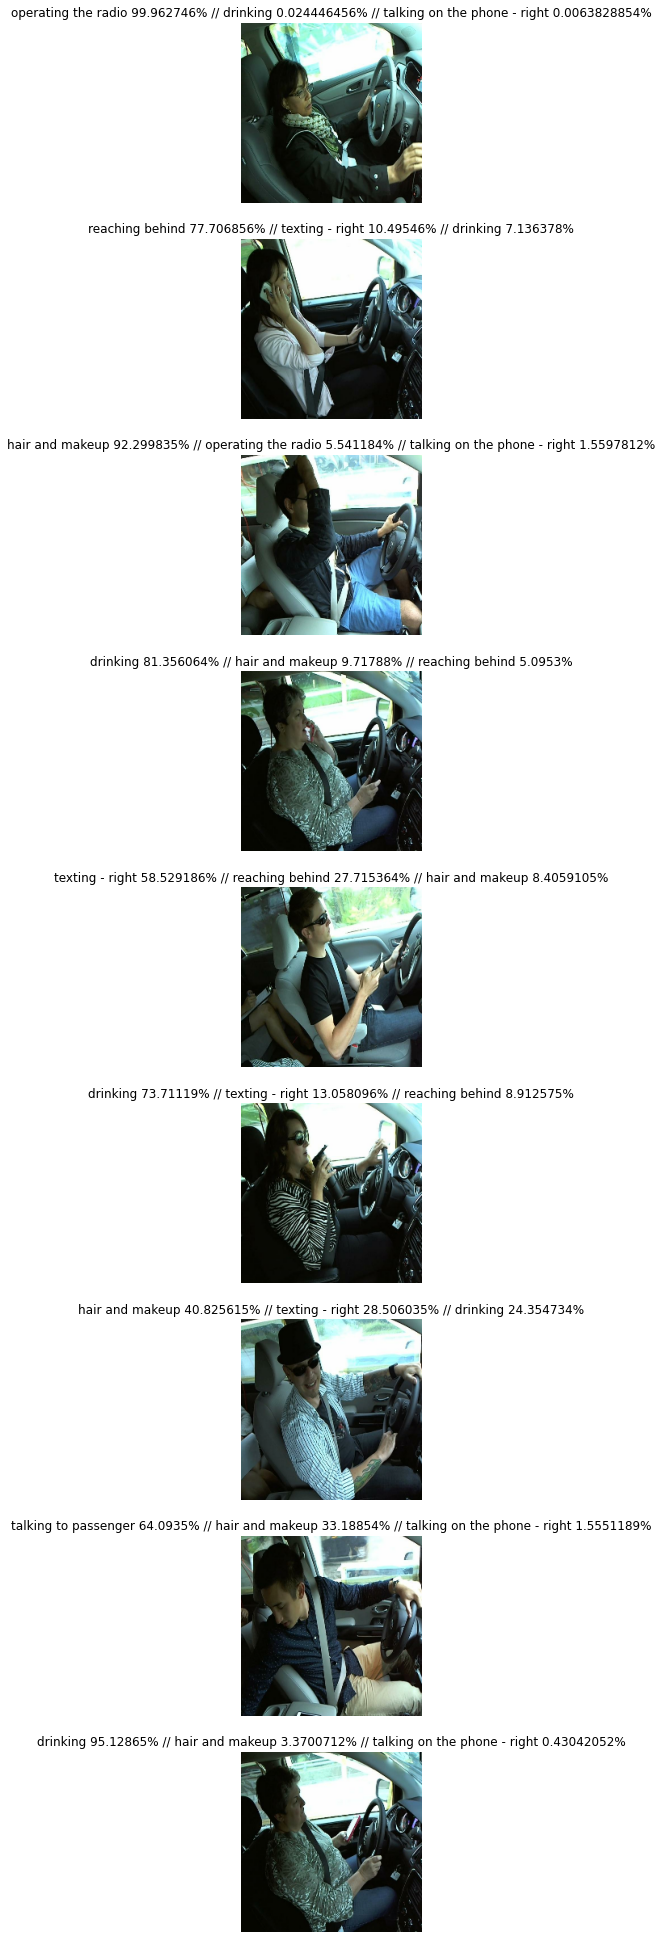

In [ ]:
"""
Como bien hemos comentado, en este caso haremos dos partes procesando 9 imagenes
    - Las tres categorías en las que con mayor probabilidad la imagen es clasificada por la red, en orden 
    descendente de probabilidad 
    - La imagen pintada
Le damos pues 10 imágenes, una de cada tipo 
"""
def buscar_prediccion(prediccion): # Saber que predicción es
    texto_prediccion = ""
    diccionario = {
        0: "safe driving",
        1: "texting - right",
        2: "talking on the phone - right",
        3: "texting - left",
        4: "talking on the phone - left",
        5: "operating the radio",
        6: "drinking",
        7: "reaching behind",
        8: "hair and makeup",
        9: "talking to passenger",
    }

    primero = np.where(prediccion == np.amax(prediccion))
    pos1 = prediccion[primero]
    prediccion[primero] = -1
    texto_prediccion1 = str(diccionario[primero[0][0]]) + " " + str(pos1[0]) + "% // "

    segundo = np.where(prediccion == np.amax(prediccion))
    pos2 = prediccion[segundo]
    prediccion[segundo] = -1
    texto_prediccion2 = str(diccionario[segundo[0][0]]) + " " + str(pos2[0]) + "% // "

    tercero = np.where(prediccion == np.amax(prediccion))
    pos3 = prediccion[tercero]
    texto_prediccion3 = str(diccionario[tercero[0][0]]) + " " + str(pos3[0]) + "%"

    texto_prediccion = texto_prediccion1 + texto_prediccion2 + texto_prediccion3

    return texto_prediccion

def pintar_test(red): # Esto nos pinta las predicciones
    rows = 14
    columns =1

    image_size = (xpixel, ypixel)

    # Generamos el dataset de test (14 imagenes)
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=r'../Dataset/imgs/imgstest/',
        image_size=image_size,
        label_mode=None,
        shuffle=False,
    )

    predicciones = red.predict(test_dataset)
    predicciones *= 100
    
    fig = plt.figure(figsize=(55, 55))

    for images in test_dataset.take(1):
        for i in range(9):
            prediccion = predicciones[i]
            texto_prediccion = buscar_prediccion(prediccion)
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
            plt.title(texto_prediccion)

# Creación del csv. Como son 3.4GB de fotos de test no se adjunta las imágenes en el entregable pero
# este es el código que hemos usado para crear el csv

def csv_test(red): 
    image_size = (xpixel, ypixel)
    
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory=r'../../imgstest/',
        image_size=image_size,
        label_mode=None,
        shuffle=False
    )
    
    predicciones = red.predict(test_dataset,verbose = 1)
    predicciones = predicciones * 100
    
    # Añadimos las predicciones
    df = pd.DataFrame(predicciones, columns = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
    df.to_csv('resultados_test.csv')

    # Añadimos el tag de el nombre de la imágen
    nombre = os.listdir('../../imgstest/test')
    df['imagen'] = nombre

pintar_test(model)
csv_test(model)

## Pruebas de diferentes redes
#### Acuerdense de ejecutar una vez sin dropout y otra con para ver cuanto cambia

### Red 2
1 solo pooling

In [ ]:
model = Modelar_red_2(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

### Red 3
2 capas anidadas antes de un pooling

In [ ]:
model = Modelar_red_3(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

### Red 4
5 capas convolucionales

In [ ]:
model = Modelar_red_4(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

### Red 5
2^15 neuronal MLP

In [ ]:
model = Modelar_red_5(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)

### Red 6
2^20 neuronas MLP

In [ ]:
model = Modelar_red_6(16, 32, 64, xpixel, ypixel, l_rate)
# si no satisface al callback esto parara
history = Entrenar(model, train, validation, epoch, batch)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.1])
plt.legend(loc='lower right')

train_loss, train_acc = Evaluar(model,train)
val_loss, val_acc = Evaluar(model,validation)